## 문제 사항
* 가끔 인식 부정확 - save_img/*_difficult.* 참조 - 거리 threshold 늘려서 다소 개선, 해결은 안됨
* 가운데 구획 필요할 수 있음 - 대응 전략

* 오른 쪽 view 자꾸 겨드랑이로 - 자세 약간 수정함, 너무 돌지 않도록 수정 v
* 툴 형상 변경 - 깊이 5cm 정도만 줄이자 에 따라 데이터 다시 수집 필요 v
* 작업 너비 너무 좁음 - 더 확실한 영역 데이터셋 준비 필요 v
* 동작 비효율적 - 일단 sweep은 task space 경로로 v
* 반대편 이동 정상 동작 안됨 !
* 이동 후 오프셋에 따라 동작 불가능해지는 상황 발생 - 미묘한 싱귤러리티 등이 원인 - 오프셋에 따른 보정 전략 도입 !


In [1]:
import os
import sys
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

from pkg.global_config import RNB_PLANNING_DIR
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.project_config import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *


CONNECT_CAM = False
CONNECT_INDY = False
CONNECT_MOBILE = False

ip_cur =  get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

Current PC IP: 192.168.0.123
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10


## Set table dimension

In [2]:
# Table dimension
T_Width = 1.8
T_Height = 0.785
T_Depth = 0.734
TOOL_DIM = [0.32, 0.08]
ROBOT_Z_ANGLE = np.pi
MARGIN = 0
OFFSET_MOBILE=[0.172, 0, 0.439]

## Prepare robot and pipeline setting

In [3]:
from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *

sock_mobile, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)

robot_config = RobotConfig(0, RobotType.indy7, None, INDY_IP, specs={"no_sdk":True})
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[robot_config]
              , connection_list=[CONNECT_INDY])

s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {"indy0": ((0,0,0), (0,0,ROBOT_Z_ANGLE))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary( -1.5, 1.5, -1, 1, -0.1, 1.75)

add_env(gscene)
viewpoint = add_cam(gscene, tool_link="indy0_tcp")
add_indy_tool_kiro(gscene, tool_link="indy0_tcp", face_name="brush_face", zoff=-0.04)

from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)
BASE_LINK = "base_link"
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

# Register binders
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
brush_face = pscene.create_binder(bname="brush_face", gname="brush_face", _type=SweepFramer, point=(-gscene.NAME_DICT['brush_face'].dims[0]/2,0,0), 
                     rpy=(0,np.pi/2*1,0))

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)
mplan.update_gscene()
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
from pkg.planning.filtering.task_clearance_filter import TaskClearanceChecker

# gcheck = GraspChecker(pscene)
# rcheck = ReachChecker(pscene)
# tcheck = TaskClearanceChecker(pscene, gcheck)
# checkers_all = [tcheck, rcheck, gcheck]
# # lcheck = LatticedChecker(pscene, gcheck)
# # checkers_all.append(lcheck)

# mplan.motion_filters = checkers_all

connection command:
indy0: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


## move indy to viewing pose

In [4]:
indy = crob.robot_dict["indy0"]
# if CONNECT_INDY:
#     with indy:
#         indy.reset_robot()

In [5]:
VIEW_POSE = np.deg2rad([  0., -28.,  85.,  -0.,  57., -180])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(Qcur)

## Attach to detection server

In [6]:
attacth_to_server()

[Errno 2] No such file or directory: 'shm://color_img'


## Get image

In [7]:
if CONNECT_CAM:
    rdict = send_recv_demo_cam({1:1}, host=CAM_HOST)

In [8]:
if CONNECT_CAM:
    rdict = stream_capture_image(ImageType.FirstView, host=CAM_HOST)
    cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]
    # Set color, depth image path
    
if CONNECT_CAM:
    color_img_path = DATASET_DIR + '/color.jpg'
    depth_img_path = DATASET_DIR + '/depth.png'
else:
    color_img_path = SAVE_DIR + '/color.jpg'
    depth_img_path = SAVE_DIR + '/depth.png'

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(color_img_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(depth_img_path, flags=cv2.IMREAD_UNCHANGED)

# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)
if mask_out is not None:
    plt.imshow(mask_out)
    # Crop masking part
    vis_mask = (mask_out * 255).astype('uint8')
    color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
    depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
    cv2.imwrite(CROP_DIR + '/color_crop.jpg', color_instance)
    cv2.imwrite(CROP_DIR + '/depth_crop.png', depth_instance)
    
    set_cam_params(cam_intrins, d_scale)
    model_mesh, pcd_out = preprocessing()
    ICP_result1 = compute_ICP(model_mesh, pcd_out, (-T_Height, -T_Depth, 0.0))
    #ICP_result2 = compute_ICP(model_mesh, pcd2)
    
if not CONNECT_CAM: # test
    ICP_result1 = np.array([[ 0.97952723,  0.00354742,  0.20128047, -0.63449415],
                            [ 0.08693341,  0.89435887, -0.43882204, -0.18267728],
                            [-0.18157366,  0.44733614,  0.87574048,  1.77040063],
                            [ 0.        ,  0.        ,  0.        ,  1.        ]])

Detect server not attached - call attach_to_server


In [9]:
gscene.show_pose(VIEW_POSE)
viewpoint.draw_traj_coords([VIEW_POSE])

[array([[ 1.63500920e-11, -4.06736601e-01,  9.13545473e-01,
          3.34365761e-01],
        [-1.00000000e+00, -3.51531197e-12,  1.63322856e-11,
          1.86499992e-01],
        [-3.43154104e-12, -9.13545473e-01, -4.06736601e-01,
          8.61139862e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])]

In [10]:
TABLE_DIMS = np.array((T_Depth,T_Width,T_Height))
OFF_DIR = np.array([1,1,-1])
# OFF_DIR = np.array([1,1,0])
#TABLE_DIMS[[0,1,2]]
#np.hstack([TABLE_DIMS[[0,1]], [0]])
T_toff = SE3(Rot_axis(3,np.pi), np.divide(TABLE_DIMS[[0,1,2]]*OFF_DIR,2))
T_co = np.matmul(np.matmul(ICP_result1, SE3(Rot_axis(1, np.pi/2), [0]*3)), T_toff)
T_lo = np.matmul(viewpoint.Toff, T_co)
T_bc = viewpoint.get_tf(list2dict(VIEW_POSE, gscene.joint_names))
T_bo=np.matmul(T_bc, T_co)

In [11]:
# fit to plane
floor_g = gscene.NAME_DICT["floor"]
floor_height = floor_g.center[2] + floor_g.dims[2]/2

# Floor Fitting
T_bo[2,3] =  floor_height+TABLE_DIMS[2]/2

# Depth scaling
# T_bfcenter = SE3(np.identity(3), [0,0,floor_height+TABLE_DIMS[2]/2])
# T_fc = np.matmul(SE3_inv(T_bfcenter), T_bc)
# T_fo = np.matmul(SE3_inv(T_bfcenter), T_bo)
# dz_cam = T_fc[2,3]
# dz_obj = -T_fo[2,3]
# dz_co = dz_cam + dz_obj
# depth_newscale = dz_cam/dz_co
# T_co_new = T_co.copy()
# T_co_new[:3,3] *= depth_newscale
# T_bo_new = np.matmul(T_bc, T_co_new)
# T_co = T_co_new
# T_bo = T_bo_new

azimuth, zenith = mat2hori(T_bo[:3,:3])
zenith_up = np.pi-zenith
Raz = Rot_axis(3, azimuth)
Rzn = Rot_axis(2, -zenith_up)
Roff = np.matmul(np.matmul(Raz, Rzn), Raz.transpose())
T_bo[:3,:3] = np.matmul(Roff, T_bo[:3,:3])

gscene.add_highlight_axis("table", "center", link_name="base_link", center=T_bo[:3,3], orientation_mat=T_bo[:3,:3])

# geometry 추가
table = gscene.create_safe(gtype=GEOTYPE.BOX, name="table", link_name="base_link", 
                   dims=TABLE_DIMS, center=T_bo[:3,3], rpy=Rot2rpy(T_bo[:3,:3]), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

## select task area

reference height: 0.536499995947


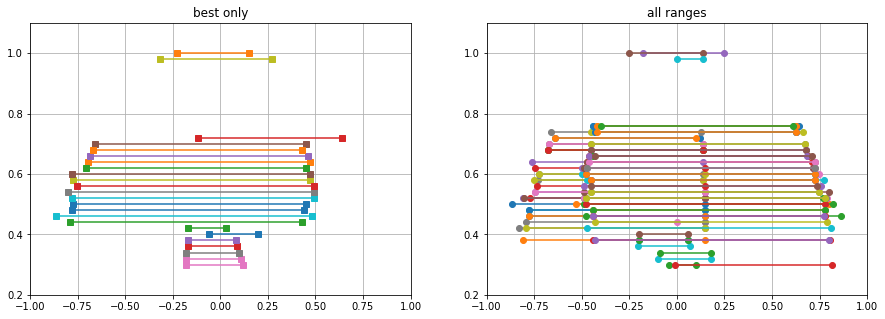

In [12]:
TABLE_HEIGHT = floor_height+TABLE_DIMS[2]
T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
P_floor_e = T_brush_e[:3,3] + [0,0,TABLE_HEIGHT]
TOOL_DEPTH_MIN = 0.6
TOOL_DEPTH_MAX = 1.0
EE_DEPTH_OFF, _, EE_HEIGHT = P_floor_e
print("reference height: {}".format(EE_HEIGHT))
if ROBOT_Z_ANGLE == np.pi:
    flipper = -1
elif ROBOT_Z_ANGLE == 0:
    flipper = 1
else:
    raise(NotImplementedError("Unexpected robot orientation"))

sweep_data = load_sweep_data(robot_config.type.name).reshape((1,))[0]
range_list_dict, best_range_dict = sweep_data['range_list_dict'], sweep_data['best_range_dict']
heights = sorted(set([key[2] for key in best_range_dict.keys()]))
i_high = np.where(np.subtract(heights, EE_HEIGHT)>=0)[0][0]
i_low = i_high-1
h_high = heights[i_high]
h_low = heights[i_low]

match_range_dict_high = defaultdict(lambda:(-1e5, 1e5))
match_range_dict_low = defaultdict(lambda:(-1e5, 1e5))
match_range_all = {}
for key, brange in best_range_dict.items():
    hkey = round(key[2], 4)
    key_new = round(flipper*key[0], 4)
    if hkey == h_low: # get minimum range from the upper and lower layers
        brange_new = tuple(reversed(np.multiply(flipper,brange)))
        range_old = -np.subtract(*match_range_dict_low[key_new])
        range_new = -np.subtract(*brange_new)
        if range_new < range_old:
            match_range_dict_low[key_new] = brange_new
            match_range_all[key_new] = range_list_dict[key]
    if hkey == h_high: # get minimum range from the upper and lower layers
        brange_new = tuple(reversed(np.multiply(flipper,brange)))
        range_old = -np.subtract(*match_range_dict_high[key_new])
        range_new = -np.subtract(*brange_new)
        if range_new < range_old:
            match_range_dict_high[key_new] = brange_new
            match_range_all[key_new] = range_list_dict[key]

match_range_dict = {}
best_keys = set(match_range_dict_high.keys()).intersection(match_range_dict_low.keys())
for key in best_keys:
    range_high = match_range_dict_high[key]
    range_low = match_range_dict_high[key]
    match_range_dict[key] = range_high if -np.subtract(*range_high) < -np.subtract(*range_low) else range_low
                
            
# plot available area
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("best only")
for k,v in match_range_dict.items():
    plt.plot(v, [k, k], '-s')
plt.axis([-1,1,0.2,1.1])
plt.grid()
plt.subplot(1,2,2)
for k,v in match_range_all.items():
    for vv in v:
        plt.plot(vv, [k, k], '-o')
plt.title("all ranges")
plt.axis([-1,1,0.2,1.1])
plt.grid()

In [13]:
DEPTH_MIN = TOOL_DEPTH_MIN+EE_DEPTH_OFF
DEPTH_MAX = TOOL_DEPTH_MAX+EE_DEPTH_OFF
division_dict_1 = get_division_dict(match_range_dict, 1, TABLE_DIMS, TOOL_DIM, 
                                    DEPTH_MIN=DEPTH_MIN, DEPTH_MAX=DEPTH_MAX, MARGIN=MARGIN)
division_dict_2 = get_division_dict(match_range_dict, 2, TABLE_DIMS, TOOL_DIM, 
                                    DEPTH_MIN=DEPTH_MIN, DEPTH_MAX=DEPTH_MAX, MARGIN=MARGIN)

== MOTION_DEPTH: 0.414 ==
== WIIPE_DEPTH: 0.414 ==
== MOTION_DEPTH: 0.414 ==
== WIIPE_DEPTH: 0.207 ==


In [14]:
divisions1_sorted = sorted(division_dict_1.items(), key=lambda item_: item_[1][-1])
divisions2_sorted = sorted(division_dict_2.items(), key=lambda item_: item_[1][-1])
divisions_sorted = sorted(division_dict_1.items()+division_dict_2.items(), key=lambda item_: item_[1][-1])
assert len(divisions_sorted) > 0, "no available table division solution"

In [15]:
division_sol = divisions_sorted[0]
depths = division_sol[0]
sweep_width, (area_width, area_depth), width_range, divisions, div_num = division_sol[1]
corner_center = ((max(*depths)+min(*depths))/2-EE_DEPTH_OFF, np.mean(width_range))
print("sweep depths: {}".format(depths))
print("divisions: {}".format(divisions))

sweep depths: (0.48, 0.7)
divisions: (2, 2)


# Main Loop

In [16]:
# for i_cn in range(4):
#     cn_cur = CornerRev[i_cn]
#     raise(NotImplementedError("copy loop to here"))

In [17]:
cn_cur = CornerRev[1]
print("== Current workspace section: {}".format(cn_cur.name))

== Current workspace section: FrontRight


## Add table on relative target location

In [18]:
from pkg.geometry.geotype import GEOTYPE
track = gscene.create_safe(GEOTYPE.BOX, "track", "base_link", (abs(area_depth),(area_width),0.01), 
                           tuple(corner_center)+(TABLE_HEIGHT-0.005,), rpy=(0,0,0), 
                           color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True)
track_face = gscene.copy_from(track, new_name="track_face", collision=False, color=(0.8,0.8,0.8,0.2))
TRACK_DIM = np.copy(track_face.dims)
track_face.dims = (3, 3, track.dims[2])
gscene.update_markers_all()

t_corner = np.divide(table.dims, 2)
f_corner = np.divide(track.dims, 2)
T_tc = SE3(corner_orientations[cn_cur], t_corner*corner_point_dirs[cn_cur])
T_fc = SE3(corner_orientations[cn_cur], f_corner*corner_point_dirs[cn_cur])
T_ft = np.matmul(T_fc, SE3_inv(T_tc))
T_bf = track.Toff
T_bt = np.matmul(T_bf, T_ft)
T_tb = SE3_inv(T_bt)
## 6 DoF pose to go
T_bb2 = np.matmul(table.Toff, T_tb)
gscene.add_highlight_axis("target", "base", "base_link", T_bb2[:3,3], T_bb2[:3,:3])

T_mb = SE3(Rot_axis(3, 0), OFFSET_MOBILE)
T_bm = SE3_inv(T_mb)
T_mm2 = np.matmul(SE3_inv(T_bm), np.matmul(T_bb2, SE3_inv(T_mb)))
T_bm2 = np.matmul(T_bm, T_mm2)
gscene.add_highlight_axis("target", "mobile", "base_link", T_bm2[:3,3], T_bm2[:3,:3])

## get_relative mobile pose

In [19]:

xy_rel = T_mm2[:2,3]
quat_rel = Rotation.from_dcm(T_mm2[:3, :3]).as_quat()
quat_zw_rel = quat_rel[-2:]
xyzw_rel = np.concatenate([xy_rel, quat_zw_rel])

if CONNECT_MOBILE:
    cur_xyzw = get_xyzw_cur()
else:
    cur_xyzw = (0,0,0,1)
    
T_approach = SE3(np.identity(3), [-0.4,0,0])
T_am_cur = T_xyzquat((cur_xyzw[:2]+(0,), (0,0)+cur_xyzw[2:]))
T_am_to = np.matmul(T_am_cur, T_mm2)
T_am_to_ready = np.matmul(T_am_to, T_approach)

tar_xy = T_am_to[:2,3].tolist()
tar_qzw = Rotation.from_dcm(T_am_to[:3,:3]).as_quat()[-2:].tolist()

tar_xy_rd = T_am_to_ready[:2,3].tolist()
tar_qzw_rd = Rotation.from_dcm(T_am_to_ready[:3,:3]).as_quat()[-2:].tolist()

tar_xyzw = tar_xy+tar_qzw
tar_xyzw_rd = tar_xy_rd+tar_qzw_rd
# raise(NotImplementedError("tar_xyzw: relative? absolute?"))
print("curre  xyzw: {}".format(np.round(cur_xyzw, 2)))
print("ready  xyzw: {}".format(np.round(tar_xyzw_rd, 2)))
print("target xyzw: {}".format(np.round(tar_xyzw, 2)))

curre  xyzw: [0 0 0 1]
ready  xyzw: [ 2.98 -1.11  0.63  0.78]
target xyzw: [ 3.06 -0.72  0.63  0.78]


```
curre  xyzw: [2.76 1.22 0.86 0.51]
ready  xyzw: [3.15 3.56 1.   0.01]
target xyzw: [2.75 3.57 1.   0.01]
```

## move mobile robot

In [20]:
if CONNECT_MOBILE:
    delta_xyzw = np.subtract(tar_xyzw, cur_xyzw)
    if (cn_cur in [Corners.FrontRight, Corners.BackRight] 
        and np.linalg.norm(delta_xyzw)<2.0
       ):
        move_steps = int(ceil(np.linalg.norm(delta_xyzw) / 0.7))
        xyzw_step = delta_xyzw/move_steps
        for i_stp in range(move_steps):
            if i_stp == move_steps-1:
                tar_cur = tar_xyzw
            else:
                tar_cur = np.add(cur_xyzw, xyzw_step*(i_stp+1))
            cur_xyzw = send_pose_wait(sock_mobile, 
                                      tar_cur, 
                                      send_ip=MOBILE_IP)
    else:
        cur_xyzw = send_pose_wait(sock_mobile, tar_xyzw_rd, send_ip=MOBILE_IP)
        cur_xyzw = send_pose_wait(sock_mobile, tar_xyzw, send_ip=MOBILE_IP)    

# # Go view loc
# cur_xyzw = send_pose_wait(sock_mobile, [2.77, 1.,   0.86, 0.51], send_ip=MOBILE_IP)

In [21]:
## add moved table in front of robot
table_front = gscene.create_safe(GEOTYPE.BOX, "table_front", "base_link", 
                                 dims=table.dims, 
                                 center=T_bt[:3,3], 
                                 rpy=Rot2rpy(T_bt[:3,:3]),
                                 color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True)

table.color = (0.8,0.8,0.8,0.0)
gscene.update_markers_all()

# corner_center_rel = np.abs(np.subtract(tuple(corner_center)+(TABLE_HEIGHT,), table_front.center))

### calc gaze pose

In [22]:
if CONNECT_INDY:
    with indy:
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE

In [23]:
GAZE_DIST = 0.5

T_bc = np.matmul(T_bt, T_tc)

if cn_cur in [Corners.FrontLeft, Corners.BackLeft]:
    T_cam_c_list = [SE3(Rot_rpy((0,-np.pi*3/4,np.pi/2)) , (0,0,GAZE_DIST))]
elif cn_cur in [Corners.FrontRight, Corners.BackRight]:
    T_cam_c_list = [SE3(Rot_rpy((np.pi/8,-np.pi*7/8,np.pi/2)) , (0,0,GAZE_DIST))]
for T_cam_c in T_cam_c_list:
    T_bcam = np.matmul(T_bc, SE3_inv(T_cam_c))
    T_ecam = viewpoint.Toff
    T_be = np.matmul(T_bcam, SE3_inv(T_ecam))
    gscene.add_highlight_axis("cam", "effector", "base_link", T_be[:3, 3], T_be[:3,:3])
    gaze_traj, success = mplan.planner.plan_py("indy0", "indy0_tcp", np.concatenate(T2xyzquat(T_be)), "base_link", Qcur)
    if success:
        gaze_pose = gaze_traj[-1]
        break

print("GAZE: {}".format(success))
if success:
    gscene.show_motion(gaze_traj)

GAZE: True


## Move to gaze pose

In [24]:
if CONNECT_INDY:
    indy.move_joint_wp(gaze_traj, None, None, None)

In [25]:
# ## return from gaze pose
# if CONNECT_INDY:
#     indy.move_joint_wp(np.array(list(reversed(gaze_traj))), None, None, None)

## Refine plane

In [26]:
if CONNECT_CAM:
    # 모서리부분 근접 촬영
    rdict = stream_capture_image(ImageType.CloseView, host=CAM_HOST)
    set_cam_params(rdict['intrins'], rdict['depth_scale'])

In [27]:
if CONNECT_CAM:
    img_path = SAVE_DIR + '/table.png'
else:
    img_path = DATASET_DIR + "/table_11.png"
    
if CONNECT_INDY:
    with indy:
        Qcur = indy.get_qcur()
else:
    try:
        Qcur = np.load(DATASET_DIR + '/tablepose_11.npy')  
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/home/rnb/Projects/rnb-planning/data/sweep_reach/tablepose_11.npy'


In [28]:
# np.save(SAVE_DIR+"/Qcur_table_right.npy", Qcur)

In [29]:
from demo_utils.detect_table import *

In [30]:
if CONNECT_CAM:
    p_inliers = get_inliers(img_path)

    T_bc = viewpoint.get_tf(list2dict(Qcur, gscene.joint_names))
    viewpoint.draw_traj_coords([Qcur])
    x_bo, y_bo = point_proj(T_bc, p_inliers)

    from pkg.utils.rotation_utils import *
    if cn_cur in [Corners.BackLeft, Corners.FrontLeft]:
        T_bo = left_corner(x_bo, y_bo)
    elif cn_cur in [Corners.BackRight, Corners.FrontRight]:
        T_bo = right_corner(x_bo, y_bo)

    gscene.add_highlight_axis("table", "center", link_name="base_link", center=T_bo[:3,3], orientation_mat=T_bo[:3,:3])

else:
    T_bo = np.matmul(track.Toff, T_ft)
    
T_bo = np.matmul(T_bo, SE3(np.identity(3), (0,0,0)))    
# geometry
table = gscene.create_safe(gtype=GEOTYPE.BOX, name="table_front", link_name="base_link", 
                   dims=TABLE_DIMS, center=T_bo[:3,3], rpy=Rot2rpy(T_bo[:3,:3]), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

## adjust track

In [31]:
from pkg.geometry.geotype import GEOTYPE
T_tf = SE3_inv(T_ft)
track = gscene.create_safe(GEOTYPE.BOX, "track", "base_link", (abs(area_depth),abs(area_width),0.01), 
                           center = T_tf[:3,3], #corner_center_rel*corner_point_dirs[cn_cur], 
                           rpy= Rot2rpy(T_tf[:3,:3]), #Rot2rpy(corner_orientations[cn_cur]), 
                           color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True,
                           parent="table_front")
track_face = gscene.copy_from(track, new_name="track_face", collision=False, color=(0.8,0.8,0.8,0.2))
TRACK_DIM = np.copy(track_face.dims)
track_face.dims = (3, 3, track.dims[2])
gscene.update_markers_all()

sweep_list, track_list = make_work_plane(pscene, TRACK_DIM, TOOL_DIM, EE_DEPTH_OFF, depths, width_range, MARGIN=MARGIN)

In [32]:
from pkg.planning.constraint.constraint_common \
            import sample_redundancy, combine_redundancy
gtimer = GlobalTimer.instance()
# initial_state = pscene.initialize_state(crob.home_pose)
initial_state = pscene.initialize_state(VIEW_POSE)
print(initial_state.node)

# # remove place points except for the current one
# use_current_place_point_only(pscene, initial_state)

(0, 0)


In [33]:
from pkg.utils.traj_utils import simplify_schedule, mix_schedule
mplan.reset_log(False)
gtimer.reset()
tplan.prepare()
mplan.update_gscene()
    
print(initial_state.node)

obj_num = 0
sweep_num = len(sweep_list)
from_state = initial_state.copy(pscene)
from_state.Q = np.array([0]*6)
# from_state.Q = np.array([ 0.        , -0.48869219,  1.48352986, -0.        ,  0.99483767,
#        3.14159265])
t_exe = None
snode_schedule_all = []
for sweep_idx in range(sweep_num):
#     gcheck.put_banned = [track_list[sweep_idx][2]]
    sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(sweep_num)])
#     sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(2)])+(0,)
    goal_nodes = [("track_face",)*obj_num+sweep_goal]
    if sweep_idx < sweep_num-1:
        for i_s in range(obj_num):
            obj_goal = ["track_face"]*obj_num
            obj_goal[i_s] = "grip1"
            goal_nodes += [tuple(obj_goal)+sweep_goal]
    gtimer.tic("plan{}".format(sweep_idx))
    ppline.search(from_state, goal_nodes, verbose=True, display=False, dt_vis=0.01, 
                  timeout_loop=10, multiprocess=True, timeout=1, timeout_constrained=2, 
                  add_homing=False, post_optimize=False)
    gtimer.toc("plan{}".format(sweep_idx))
    schedules = ppline.tplan.find_schedules(False)
    schedules_sorted = ppline.tplan.sort_schedule(schedules)
    snode_schedule = ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0])
    if sweep_idx == 0:
        snode_start = snode_schedule[1]
        pscene.set_object_state(snode_schedule[0].state)
        trajectory, success = mplan.planner.plan_joint_motion_py(
            ROBOT_NAME, tuple(snode_start.traj[-1]), tuple(gaze_pose), timeout=1)
        if success:
            snode_start.traj = trajectory
    if sweep_idx == sweep_num-1:
        added_list = ppline.add_return_motion(snode_schedule[-1], initial_state=initial_state, timeout=0.5, try_count=2)
        snode_schedule += added_list
    snode_schedule_ori = snode_schedule
    snode_schedule_simple = simplify_schedule(pscene, snode_schedule)
#     snode_schedule_safe = calculate_safe_schedule(pscene, snode_schedule_simple, 5, 1)
#     double_sweep_motions(snode_schedule_safe)
#     snode_schedule = snode_schedule_safe
#     snode_schedule = mix_schedule(mplan, snode_schedule_safe)
    snode_schedule = snode_schedule_simple
    from_state = snode_schedule[-1].state
    snode_schedule_all.append(snode_schedule)

(0, 0)
Use 36/36 agents
try: 0 - (0, 0)->(1, 0)
try: 0 - (0, 0)->(0, 1)
try transition motion
try: 0 - (0, 0)->(0, 1)
try transition motion
try: 0 - (0, 0)->(1, 0)
try transition motion
try: 0 - (0, 0)->(0, 1)
try: 0 - (0, 0)->(1, 0)
try transition motion
try transition motion
try transition motion
try: 0 - (0, 0)->(1, 0)
try transition motion
try: 0 - (0, 0)->(1, 0)
try transition motion
try: 0 - (0, 0)->(1, 0)
transition motion tried: True
try transition motion
result: 0 - (0, 0)->(0, 1) = success
branching: 0->1 (0.13/10.0 s, steps/err: 37(79.3528556824 ms)/0.00197548649205)
transition motion tried: True
try: 0 - (0, 0)->(0, 1)
try: 0 - (0, 0)->(0, 1)
try: 0 - (0, 0)->(1, 0)
try: 1 - (0, 1)->(0, 2)
transition motion tried: True
result: 0 - (0, 0)->(0, 1) = success
try transition motion
try transition motion
try transition motion
branching: 0->2 (0.15/10.0 s, steps/err: 37(82.4429988861 ms)/0.00197548649205)
transition motion tried: True
try: 0 - (0, 0)->(0, 1)
result: 0 - (0, 0)->(1

try constrained motion
try: 16 - (0, 1)->(0, 2)
joint min
transition motion tried: True
try: 0 - (0, 0)->(0, 1)
try transition motion
joint min
result: 0 - (0, 0)->(0, 1) = success
try constrained motion
branching: 0->21 (1.4/10.0 s, steps/err: 37(104.193925858 ms)/0.00203947852762)
constrained motion tried: False
constrained motion tried: False
Motion Plan Failure
transition motion tried: True
try: 0 - (0, 0)->(1, 0)
result: 0 - (0, 0)->(1, 0) = success
branching: 0->22 (1.42/10.0 s, steps/err: 49(130.630970001 ms)/0.00101035563912)
try transition motion
Motion Plan Failure
result: 5 - (0, 1)->(0, 2) = fail
result: 11 - (0, 1)->(0, 2) = fail
try: 22 - (1, 0)->(2, 0)
try: 0 - (0, 0)->(1, 0)
try: 0 - (0, 0)->(0, 1)
try transition motion
try constrained motion
try transition motion
transition motion tried: True
transition motion tried: True
result: 0 - (0, 0)->(0, 1) = success
joint min
result: 0 - (0, 0)->(1, 0) = success
branching: 0->23 (1.51/10.0 s, steps/err: 43(95.1931476593 ms)/0.

result: 0 - (0, 0)->(0, 1) = success
branching: 0->37 (2.48/10.0 s, steps/err: 37(202.23402977 ms)/0.00197548649205)
branching: 0->38 (2.5/10.0 s, steps/err: 43(300.934076309 ms)/0.00100932430229)
try: 35 - (1, 0)->(2, 0)
branching: 0->39 (2.52/10.0 s, steps/err: 43(286.072969437 ms)/0.00145250508415)
try: 0 - (0, 0)->(0, 1)
try: 40 - (1, 0)->(2, 0)
try: 5 - (0, 1)->(0, 2)
result: 0 - (0, 0)->(1, 0) = success
transition motion tried: True
try constrained motion
try transition motion
try constrained motion
branching: 0->40 (2.57/10.0 s, steps/err: 42(218.1661129 ms)/0.00203873031531)
try: 39 - (0, 1)->(0, 2)
try constrained motion
transition motion tried: True
try constrained motion
result: 0 - (0, 0)->(0, 1) = success
try: 0 - (0, 0)->(0, 1)
result: 0 - (0, 0)->(1, 0) = success
branching: 0->42 (2.64/10.0 s, steps/err: 55(198.974132538 ms)/0.001291371792)
branching: 0->41 (2.63/10.0 s, steps/err: 37(202.0008564 ms)/0.00197548649205)
try transition motion
try: 42 - (1, 0)->(2, 0)
try: 2

try: 0 - (0, 0)->(1, 0)
try: 29 - (1, 0)->(2, 0)
joint min
transition motion tried: True
try transition motion
transition motion tried: True
try constrained motion
try transition motion
constrained motion tried: False
result: 0 - (0, 0)->(1, 0) = success
constrained motion tried: False
try: 55 - (1, 0)->(2, 0)
Motion Plan Failure
branching: 0->55 (4.49/10.0 s, steps/err: 55(264.139890671 ms)/0.00143214123145)
try constrained motion
try constrained motion
result: 0 - (0, 0)->(0, 1) = success
try: 0 - (0, 0)->(1, 0)
Motion Plan Failure
joint min
branching: 0->56 (4.52/10.0 s, steps/err: 37(157.194852829 ms)/0.00197548649205)
result: 6 - (1, 0)->(2, 0) = fail
try transition motion
result: 35 - (1, 0)->(2, 0) = fail
end
try: 10 - (1, 0)->(2, 0)
try: 0 - (0, 0)->(1, 0)
constrained motion tried: False
try constrained motion
transition motion tried: True
Motion Plan Failure
try transition motion
try: 0 - (0, 0)->(1, 0)
constrained motion tried: True
result: 0 - (0, 0)->(0, 1) = success
try tr

result: 18 - (0, 1)->(0, 2) = fail
Motion Plan Failure
joint min
result: 32 - (0, 1)->(0, 2) = fail
constrained motion tried: False
======================= terminated 26: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
======================= terminated 32: first answer acquired from other agent ===============================
result: 21 - (0, 1)->(0, 2) = fail
joint max
Motion Plan Failure
======================= terminated 25: first answer acquired from other agent ===============================
result: 25 - (1, 0)->(2, 0) = fail
constrained motion tried: False
Motion Plan Failure
joint min
result: 47 - (0, 1)->(0, 2) = fail
constrained motion tried: False
======================= terminated 18: first answer acquired from other agent ===============================
Motion Plan Failure
result: 5 - (0, 1)->(0, 2) = fail
======================= terminated 31: first answer acquired from other agent ===============

constrained motion tried: False
Motion Plan Failure
result: 1 - (0, 1)->(0, 2) = fail
======================= terminated 28: first answer acquired from other agent ===============================
joint min
constrained motion tried: False
Motion Plan Failure
result: 13 - (0, 1)->(0, 2) = fail
end
constrained motion tried: True
======================= terminated 7: first answer acquired from other agent ===============================
result: 42 - (1, 0)->(2, 0) = success
branching: 42->69 (5.76/10.0 s, steps/err: 103(3038.875103 ms)/0.0684155261238)
======================= terminated 12: first answer acquired ===============================
try: 0 - (2, 0)->(2, 1)
try transition motion
try: 0 - (2, 0)->(2, 1)
try transition motion
try: 0 - (2, 0)->(2, 1)
try transition motion
try: 0 - (2, 0)->(2, 1)
end
try transition motion
try: 0 - (2, 0)->(2, 1)
constrained motion tried: True
result: 53 - (1, 0)->(2, 0) = success
transition motion tried: True
try transition motion
branching: 53->70 (

======================= terminated 10: first answer acquired from other agent ===============================
end
constrained motion tried: True
result: 3 - (2, 1)->(2, 2) = success
branching: 3->12 (2.19/10.0 s, steps/err: 103(1277.22001076 ms)/0.0488019290232)
======================= terminated 1: first answer acquired ===============================
end
constrained motion tried: True
result: 2 - (2, 1)->(2, 2) = success
branching: 2->13 (2.24/10.0 s, steps/err: 103(1365.55194855 ms)/0.0488019290232)
======================= terminated 7: first answer acquired ===============================
======================= terminated 11: first answer acquired from other agent ===============================
======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated 16: first answer acquired from othe

======================= terminated 31: first answer acquired from other agent ===============================
end
======================= terminated 33: first answer acquired from other agent ===============================
constrained motion tried: True
result: 4 - (2, 1)->(2, 2) = success
======================= terminated 32: first answer acquired from other agent ===============================
branching: 4->15 (2.4/10.0 s, steps/err: 103(1411.98801994 ms)/0.0488019290232)
======================= terminated 34: first answer acquired from other agent ===============================
======================= terminated 35: first answer acquired from other agent ===============================
======================= terminated 3: first answer acquired ===============================
end
constrained motion tried: True
result: 5 - (2, 1)->(2, 2) = success
branching: 5->16 (2.43/10.0 s, steps/err: 103(1442.964077 ms)/0.0488019290232)
======================= terminated 4: first answer acqu

## Refine sweep motion

In [36]:
from demo_utils.refine_sweep import simplify_sweep
for snode_schedule in snode_schedule_all:
    simplify_sweep(pscene, mplan, snode_schedule, len_traj=20)

## Play plan

In [37]:
for snode_schedule in snode_schedule_all:
    ppline.play_schedule(snode_schedule, period=0.1)

(0, 0)->(0, 0)
(0, 0)->(1, 0)
(1, 0)->(2, 0)
(2, 0)->(2, 0)
(2, 0)->(2, 1)
(2, 1)->(2, 2)
(2, 2)->(2, 2)


## Execute plan

In [76]:
if CONNECT_INDY:
    for snode_schedule in snode_schedule_all:
        ppline.execute_schedule(snode_schedule, one_by_one=True)
        with indy:
            time.sleep(0.5)
            indy.wait_for_move_finish()
            
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
binder: brush_face
rname: indy0
binder: None
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
binder: brush_face
rname: indy0
binder: None
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
binder: brush_face
rname: indy0
binder: None
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Move finished!


## Test sweep manually

In [132]:
from pkg.utils.rotation_utils import *
from pkg.planning.constraint.constraint_subject import SweepLineTask
from pkg.utils.utils import list2dict

def get_jacobian(gscene, gtem, Q):
    Q_dict = list2dict(Q, gscene.joint_names)
    Jac = []
    for ij, jname in enumerate(gscene.joint_names):
        joint = gscene.urdf_content.joint_map[jname]
        Tj = T_xyzrpy((joint.origin.xyz, joint.origin.rpy))
        T_link = get_tf(joint.parent, Q_dict, gscene.urdf_content)
        T_bj = np.matmul(T_link, Tj)
        zi = np.matmul(T_bj[:3, :3], joint.axis)
        T_p = gtem.get_tf(Q_dict)
        dpi = T_p[:3, 3] - T_bj[:3, 3]
        zp = np.cross(zi, dpi)
        Ji = np.concatenate([zp, zi])
        Jac.append(Ji)
    Jac = np.array(Jac).transpose()
    return Jac

for k, v in ppline.tplan.snode_dict.items():
    gscene.show_motion(snode.traj)


    SINGULARITY_CUT = 0.01
    len_traj = 100

    Qi = snode.traj[-1]
    Qidict = list2dict(Qi, gscene.joint_names)
    Ti = gtem.get_tf(Qidict)

    dP = wp2.Toff[:3,3] - wp1.Toff[:3,3]
    dPabs = np.linalg.norm(dP)
    DP = dPabs / len_traj
    DIR = np.concatenate([dP / dPabs, [0] * 3])
    Q = Qi


    singularity = False
    Traj_wipe = [Qi]

    for _ in range(len_traj):
        Jac = get_jacobian(gscene, gtem, Q)
        if np.min(np.abs(np.real(np.linalg.svd(Jac)[1]))) <= SINGULARITY_CUT:
            singularity = True
            print("singular")
#             break
        Jinv = np.linalg.inv(Jac)
        dQ = np.matmul(Jinv, np.multiply(DIR, DP))
        Q = Q + dQ
        Traj_wipe.append(Q)
        dlim = np.subtract(RobotSpecs.get_joint_limits(RobotType.indy7), Q[:, np.newaxis])
        if np.any(dlim[:, 0] > 0):
            print("min lim: {}".format(np.where(dlim[:, 0] > 0)[0]))
            break
        if np.any(dlim[:, 1] < 0):
            print("max lim: {}".format(np.where(dlim[:, 1] < 0)[0]))
            break
    #         if not mplan.validate_trajectory([Q]):
    #             print("col")
    #             break
    #         Tnew = gtem.get_tf(list2dict(Q, gscene.joint_names))
    #         if np.abs(Ti[0,3]-Tnew[0,3])>0.01:
    #             print("off")
    #             break
    gscene.show_motion(Traj_wipe)

    Traj_wipe = np.array(Traj_wipe)

## test saved param

In [46]:
Tcur = get_tf(mplan.sweep_params[0], mplan.sweep_params[1], mplan.sweep_params[2], mplan.sweep_params[3])
T_tar_tool = mplan.sweep_params[-1]

ee_point = gscene.create_safe(GEOTYPE.SPHERE, "end_point", TIP_LINK, (0.01,)*3, 
                              center=(0,0,0), rpy=(0,0,0), 
                              color=(0.8,0.2,0.2,0.8), display=True, fixed=True, collision=False)

from_Q_dict = mplan.sweep_params[1]
from_Q = dict2list(from_Q_dict, gscene.joint_names)

trajectory = get_sweep_traj(mplan, brush_face.geometry, np.subtract(T_tar_tool[:3,3], Tcur[:3, 3]),
                            from_Q, DP=0.01, ERROR_CUT=0.01, SINGULARITY_CUT = 0.01, VISUALIZE=True, 
                            VERBOSE=True)

Tnew = get_tf(mplan.sweep_params[0], list2dict(trajectory[-1], gscene.joint_names), mplan.sweep_params[2], mplan.sweep_params[3])
success = np.sum(np.abs(Tcur[:3,3]-Tnew[:3,3]))<1e-2